In [15]:
import os

# Evaluating the SemEval2020 task
This notebook is to evaluate several (historical) language models for English on the [SemEval2020 Shared Task](https://aclanthology.org/2020.semeval-1.1) on semantic change prediction.
We only consider the datafiles for English. This shared task contains two corpora for English:
* Corpus 1: time period 1810-1860
* Corpus 2: 1960-2010
In addition, it contains a list of target words for which the semantic shift is to be predicted. It contains both a golden truth for binary classification (shifted or not shifted?) and for ranked shift prediction (list of words is ranked on how much the word shifted). Originally, the corpora were only provided in lemmatized form, but after the contest also the original tokens were released. We use the latter, as modern contextualized embedding models use complete sentences with words.

I only evaluate subtask 2 (ranked shift prediction) for English and I reuse the code of [Kutosov and Giulianelli](https://github.com/Semantics-of-Sustainability/semeval2020) to go from contextualized embeddings to ranked shifts and evaluate these against the gold truth. They provide three different ways of calculating shift from contextualized embeddings:
* inverted cosine similarity
* average pairwise distance
*  Jensen Shannon Divergence
See [their paper](https://arxiv.org/abs/2005.00050) for more details. 
Their method ranks highest on task 2 in the post-evaluation leaderboard, using bert-base-cased.

The models that we try out are:
- bert-base-uncased (trained only on modern data)
- [HistLM](https://github.com/Living-with-machines/histLM) (started with bert-base-uncased, then finetuned on books from 1760-1900)
- [MacBERTh](https://huggingface.co/emanjavacas/MacBERTh/tree/main) (prerained on texts from 1473-1950)
- [TemporalAttention](https://github.com/Semantics-of-Sustainability/temporal_attention) (different models for the two different time periods defined in the SemEval task)

To replicate the steps this notebook, you need to also:
- Clone the [HistLM](https://github.com/Living-with-machines/histLM) repository
- Clone our fork of the [TemporalAttention](https://github.com/Semantics-of-Sustainability/temporal_attention) repository
- Download the [Evaluation data for SemEval2020](https://competitions.codalab.org/competitions/20948#learn_the_details-data). You need to create a login to download the data. Extract the data and put it in a data directory one level above this repository (so relative to this notebook, you should have the folder `../../data/semeval2020_ulscd_eng`)
- To run the Temporal Attention model, you need to rename / move some of the data files to get it to work:
```
mkdir -p temporal_attention/data/semeval_eng
cp data/semeval2020_ulscd_eng/corpus1/token/ccoha1.txt temporal_attention/data/semeval_eng/ccoha_1.txt
cp data/semeval2020_ulscd_eng/corpus1/token/ccoha2.txt temporal_attention/data/semeval_eng/ccoha_2.txt
cp -r data/semeval2020_ulscd_eng/truth temporal_attention/data/semeval_eng/
```

In the end, my directory structure looks like this:
```
.
├── DiachronicLanguageModels
│   ├── data
│   ├── notebooks
│   └── scripts
├── data
│   ├── HistBERT-full
│   └── semeval2020_ulscd_eng
│       ├── corpus1
│       │   ├── lemma
│       │   └── token
│       ├── corpus2
│       │   ├── lemma
│       │   └── token
│       └── truth
├── histLM
│   ├── ...
├── semeval2020
│   ├── ...
└── temporal_attention
    ├── __pycache__
    ├── data
    │   ├── semeval_eng
    │       └── truth
    ├── models
    │   └── tempobert
    │       └── __pycache__
    └── temp_att_model_semeval_eng
```

## Step 1: removing pos tag from semeval data
The target words contain the pos tags, create a file without pos tags, so that we can match the words in the corpora:

In [16]:
# Remove the POS tags from the targets
inp_filename = '../../data/semeval2020_ulscd_eng/targets.txt'
outp_filename = '../../data/semeval2020_ulscd_eng/targets_nopos.txt'

with open(outp_filename, 'w') as fout:
    with open(inp_filename) as fin:
        for line in fin.readlines():
            word = line.split('_')[0]
            fout.write(word)
            fout.write('\n')

## Step 2: run embeddings for each model
Run the script [semeval2020/code/bert/collect.py](https://github.com/akutuzov/semeval2020/blob/master/code/bert/collect.py) for the different models and for the two copora. For example for bert-base-uncased, and corpus1:
```bash
cd semeval2020
python code/bert/collect.py data/configs/bert-base-uncased.txt ../data/semeval2020_ulscd_eng/corpus1/token/ccoha1.txt ../data/semeval2020_ulscd_eng/targets_nopos.txt ../data/corpus1_bert-base-uncased.npz
```

For the temporal attention model, I used the [adjusted code for semantic change detection](https://github.com/Semantics-of-Sustainability/temporal_attention/blob/main/semantic_change_detection.py). Note that this script also computes a score, but this is based only on cosine distance between embedding centroid. To have a fair comparison, I also output the raw embeddings of all target words. I did not manage yet to output embeddings of all layers, so the dimension of the embedding is much smaller than for the other models.


## Step 3: output list of words for each model.
The models will not have all words from the list in their vocabulary. The code below outputs for each model, the words that were retrieved from the corpus. (A future step could be to edit the code from Kutuzov so that it also retrieves embeddings for words from outside its vocabulary).

In [17]:
import numpy as np

def output_words(corpus_filepath1, corpus_filepath2, output_file):
    test_corpus_file1 = np.load(corpus_filepath1)
    test_corpus_file2 = np.load(corpus_filepath2)
    words = set(test_corpus_file1.files).intersection(test_corpus_file2.files)
    with open(output_file, 'w') as fout:
        for word in words:
            fout.write(word+'\n')

In [21]:
output_words('../../data/corpus1_macberth.npz', '../../data/corpus2_macberth.npz', '../../data/targets_macberth.txt')

In [19]:
output_words('../../data/corpus1_bert-base-uncased.npz', '../../data/corpus2_bert-base-uncased.npz', '../../data/targets_bert-base-uncased.txt')

In [20]:
output_words('../../data/corpus1_histLM.npz','../../data/corpus2_bert-base-uncased.npz', '../../data/targets_histlm.txt')

In [14]:
output_words('../../temporal_attention/data/semeval_eng/corpus1.npz',
             '../../temporal_attention/data/semeval_eng/corpus1.npz', 
             '../../data/targets_temporalattention.txt')

## Step 4: calculate the shifts
Run the shift predictions as [described here](https://github.com/akutuzov/semeval2020#estimating-semantic-change). For example:
```
python code/distance.py ../data/targets_bert-base-uncased.txt  ../data/corpus1_bert-base-uncased.npz  ../data/corpus2_bert-base-uncased.npz ../data/semeval2020_ulscd_eng/prediction_bert-base-uncased_apd.txt
```

NB: for the HistLM model, I applied it only on corpus1 and compared it to the bert-base-uncased embeddings of corpus2, because the HistLM model was finetuned from bert-base-uncased to data from before 1900.


## Step 5: Evaluate the predictions

In [1]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
# These are the 'true' semantic shifts from subtask 2
targets = pd.read_csv('../../data/semeval2020_ulscd_eng/truth/graded.txt', sep='\t', header=None)
targets.columns = ['word_pos', 'score']
targets['word'] = [w.split('_')[0] for w in targets['word_pos']]
targets = targets.sort_values('score')
targets['rank'] = range(len(targets))
targets.head()

,word_pos,score,word,rank
4,chairman_nn,0.000000,chairman,0
28,risk_nn,0.000000,risk,1
10,fiction_nn,0.020723,fiction,2
27,relationship_nn,0.056218,relationship,3
34,tree_nn,0.070839,tree,4


In [3]:
def load_predictions(filepath, targets):
    predictions = pd.read_csv(filepath, sep='\s+', header=None)
    predictions.columns = ['word', 'score']
    scores_merged = predictions.merge(targets, on='word', how='right', suffixes=('_pred', '_true'))

    # For those words where we don't have a predicted score, take the mean score
    scores_merged['in_model'] = ~scores_merged['score_pred'].isna()
    scores_merged.loc[~scores_merged['in_model'], 'score_pred'] = predictions['score'].mean()

    # Calculate the rank
    scores_merged = scores_merged.sort_values('score_pred')
    scores_merged['rank_pred'] = range(len(scores_merged))
    scores_merged = scores_merged.rename({'rank': 'rank_true'}, axis='columns')
    return scores_merged

In [4]:
def plot_predictions(predictions, name):
    correlation, pvalue = spearmanr(predictions['score_true'], predictions['score_pred'])
    plt.figure(figsize=(20,10))
    plt.scatter(x=predictions['rank_true'], 
            y=predictions['rank_pred'])
    for i in range(len(predictions)):
        plt.text(x=predictions['rank_true'][i],
            y=predictions['rank_pred'][i],
            s=predictions['word'][i])
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{name}: {correlation:.3f}, {pvalue:.3f}')
    plt.show()
    return correlation, pvalue

In [5]:
from pathlib import Path
prediction_path = Path('../data/semeval2020/')
models = [
    [prediction_path / 'prediction_cosine_macberth.txt', 'macberth', 'cosine'],
    [prediction_path / 'prediction_apd_macberth.txt', 'macberth', 'apd'],
    [prediction_path / 'prediction_jsd_macberth.txt', 'macberth', 'jsd'],
    [prediction_path / 'prediction_bert-base-uncased_cosine.txt', 'bert-base-uncased', 'cosine'],
    [prediction_path / 'prediction_bert-base-uncased_apd.txt', 'bert-base-uncased', 'apd'],
    [prediction_path / 'prediction_histLM_bertbase_cosine.txt', 'histLM', 'cosine'],
    [prediction_path / 'prediction_histLM_bertbase_adp.txt', 'histLM', 'apd'],
    [prediction_path / 'prediction_temporalattention_cosine.txt', 'temporal_attention', 'cosine'],
    [prediction_path / 'prediction_temporalattention_apd.txt', 'temporal_attention', 'apd']
]
models_df = pd.DataFrame(models, columns=['filename', 'model', 'method'])
models_df

,filename,model,method
0,..\data\semeval2020\prediction_cosine_macberth...,macberth,cosine
1,..\data\semeval2020\prediction_apd_macberth.txt,macberth,apd
2,..\data\semeval2020\prediction_jsd_macberth.txt,macberth,jsd
3,..\data\semeval2020\prediction_bert-base-uncas...,bert-base-uncased,cosine
4,..\data\semeval2020\prediction_bert-base-uncas...,bert-base-uncased,apd
5,..\data\semeval2020\prediction_histLM_bertbase...,histLM,cosine
6,..\data\semeval2020\prediction_histLM_bertbase...,histLM,apd
7,..\data\semeval2020\prediction_temporalattenti...,temporal_attention,cosine
8,..\data\semeval2020\prediction_temporalattenti...,temporal_attention,apd


In [6]:
predictions_dict = {i: load_predictions(row['filename'], targets) for i, row in models_df.iterrows()}


In [7]:
models_df['nr_words'] = [predictions_dict[i]['in_model'].sum() for i in models_df.index]

## Plots
Plot the predicted ranking vs the true ranking of the words. The closer to the diagonal the points are, the better the models scores. The correlation and p-value are denoted in the plot title.

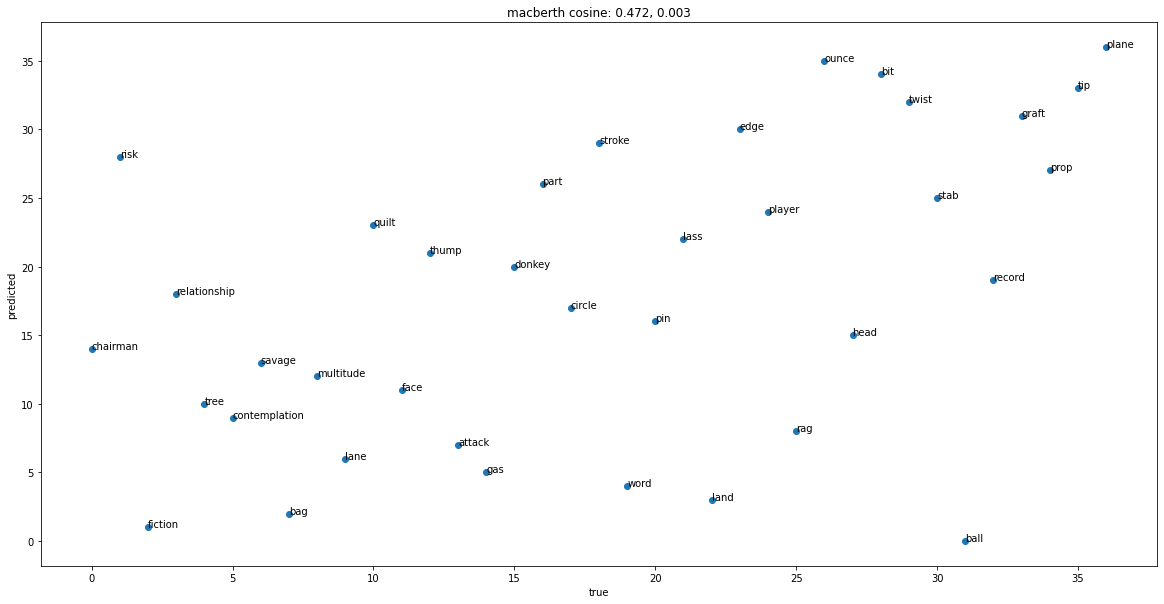

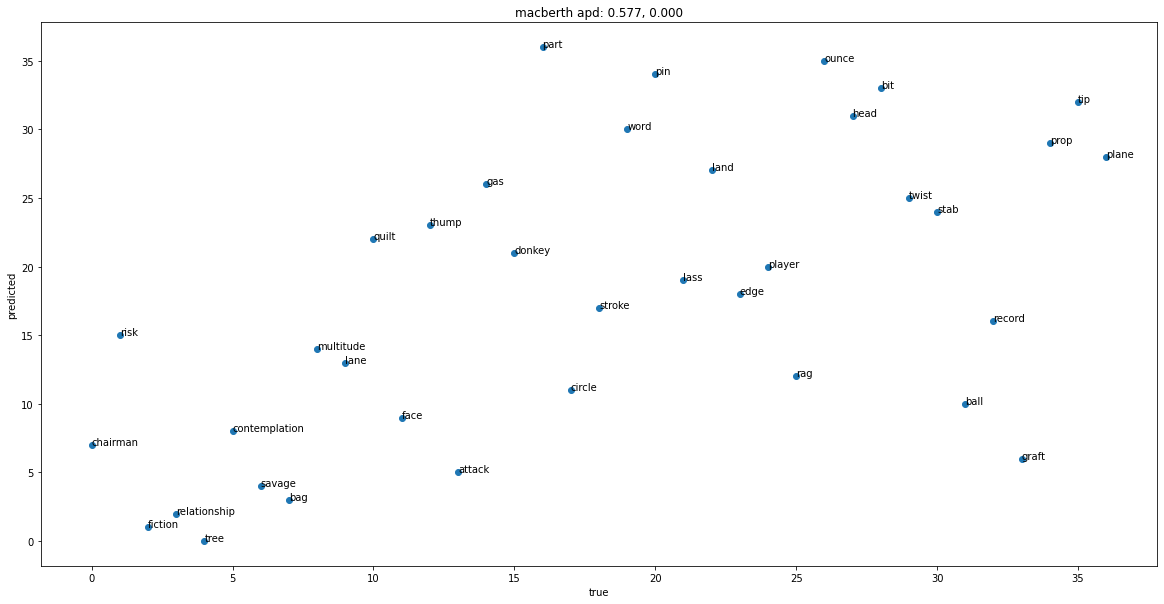

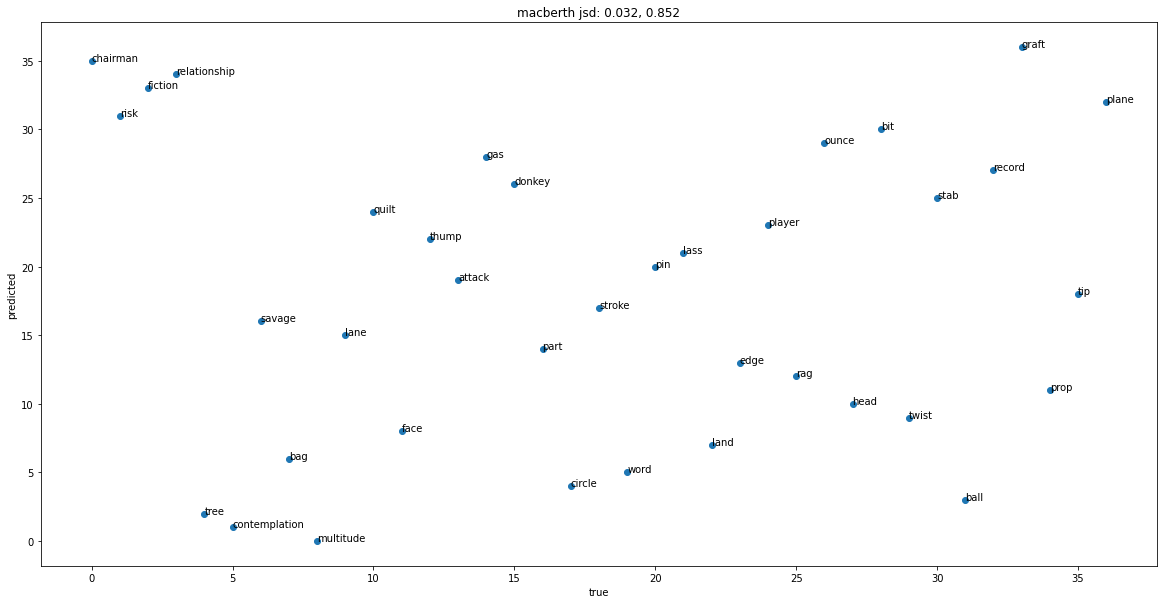

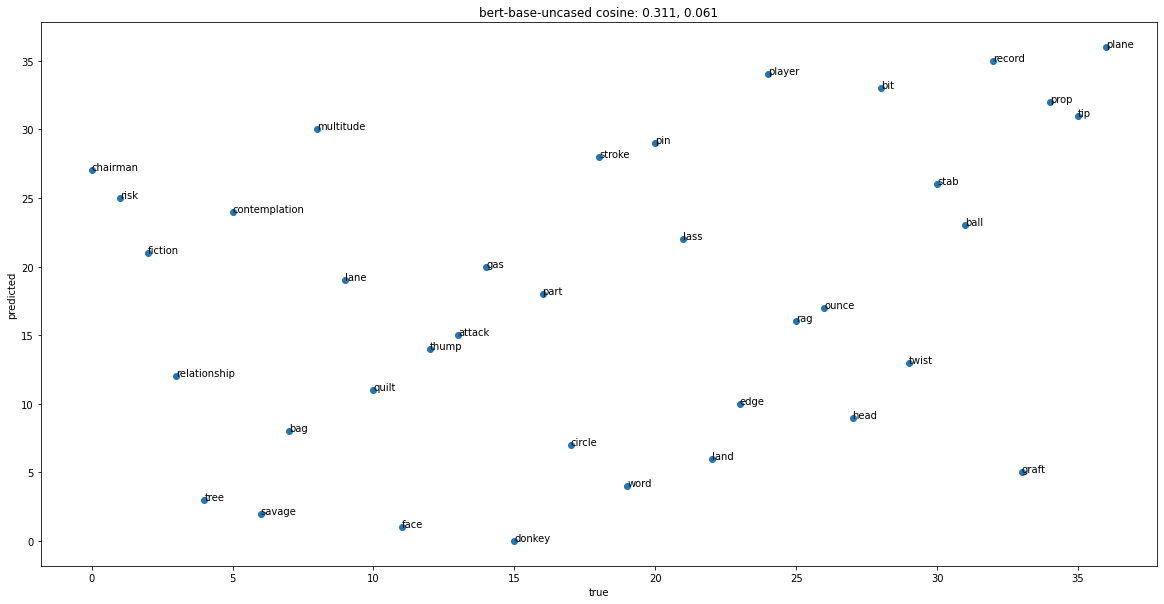

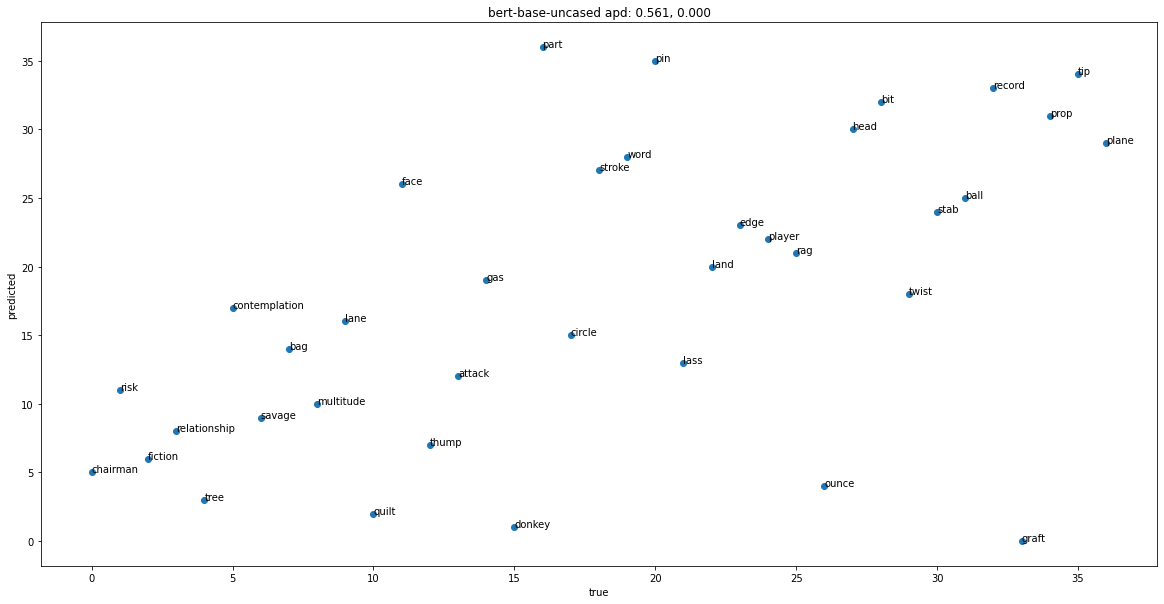

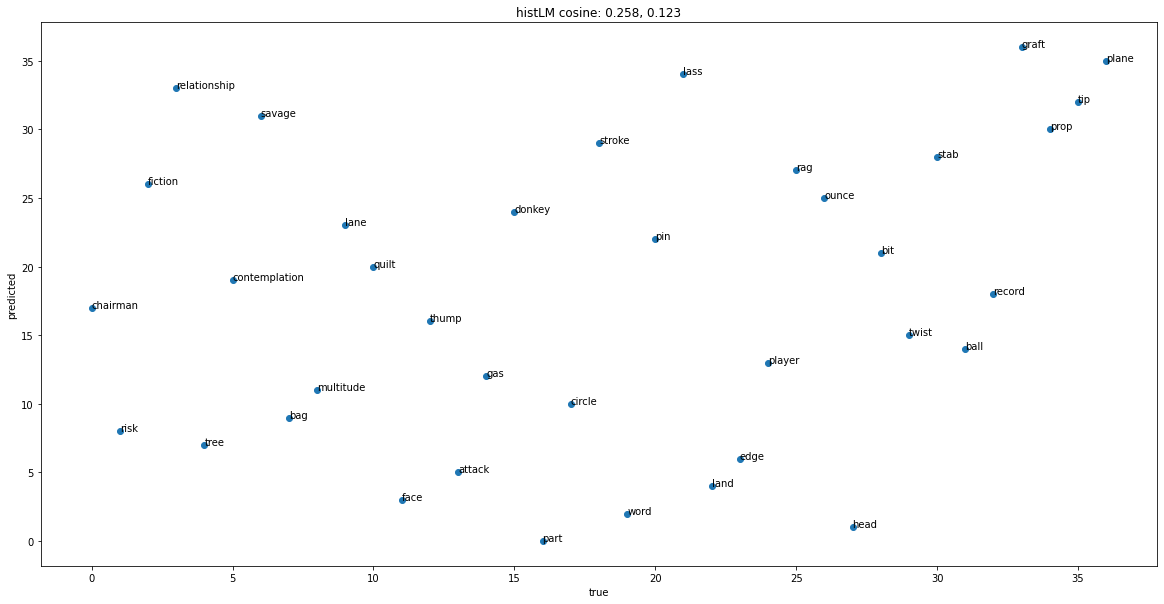

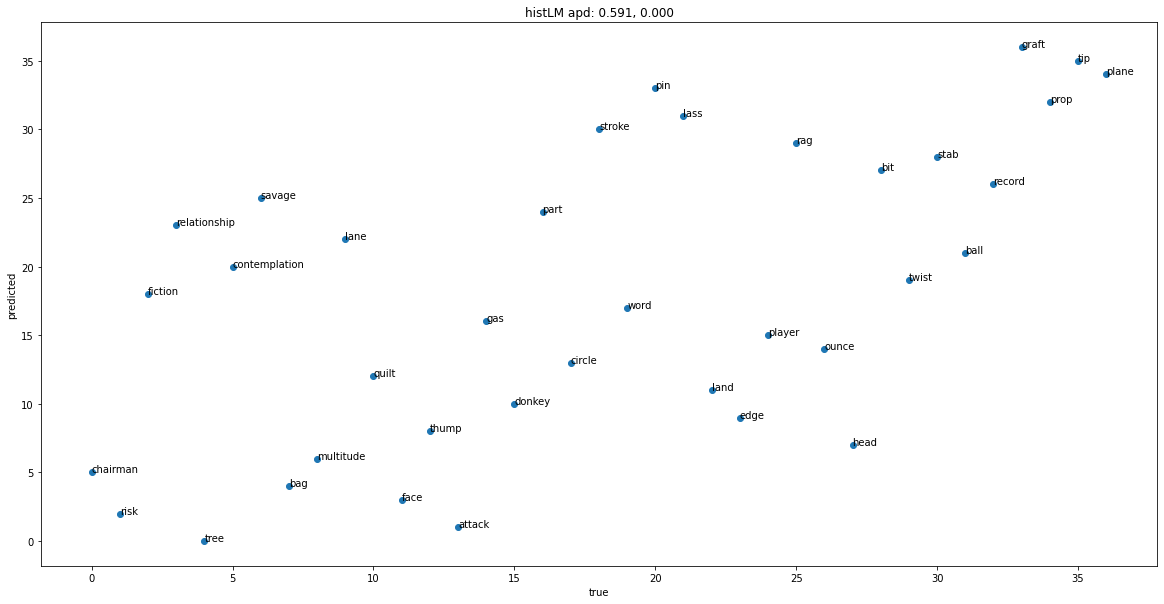

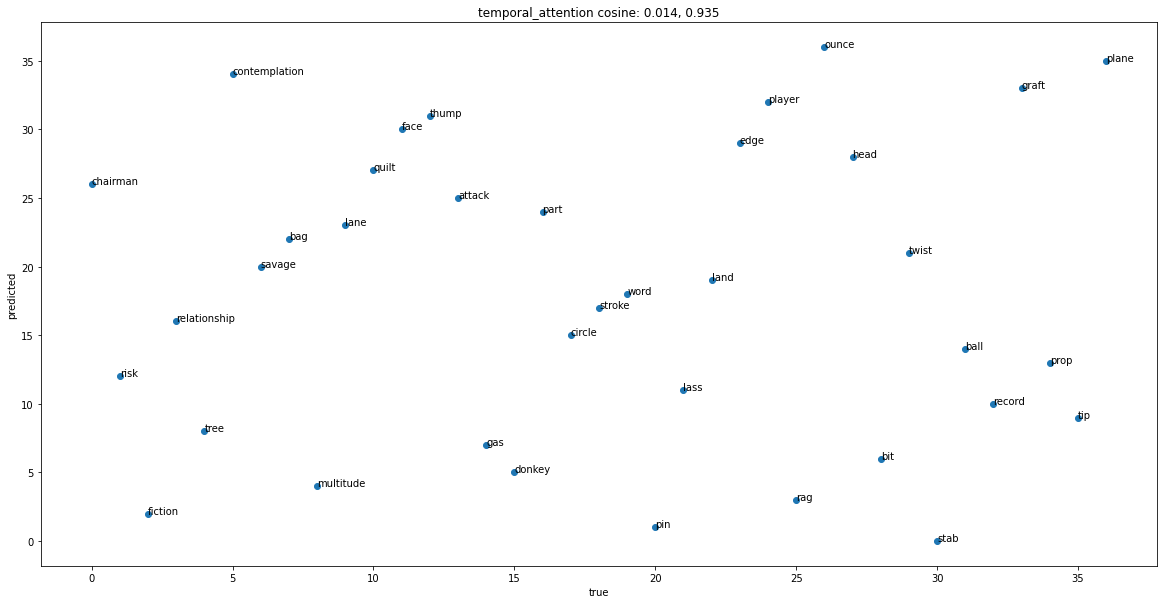

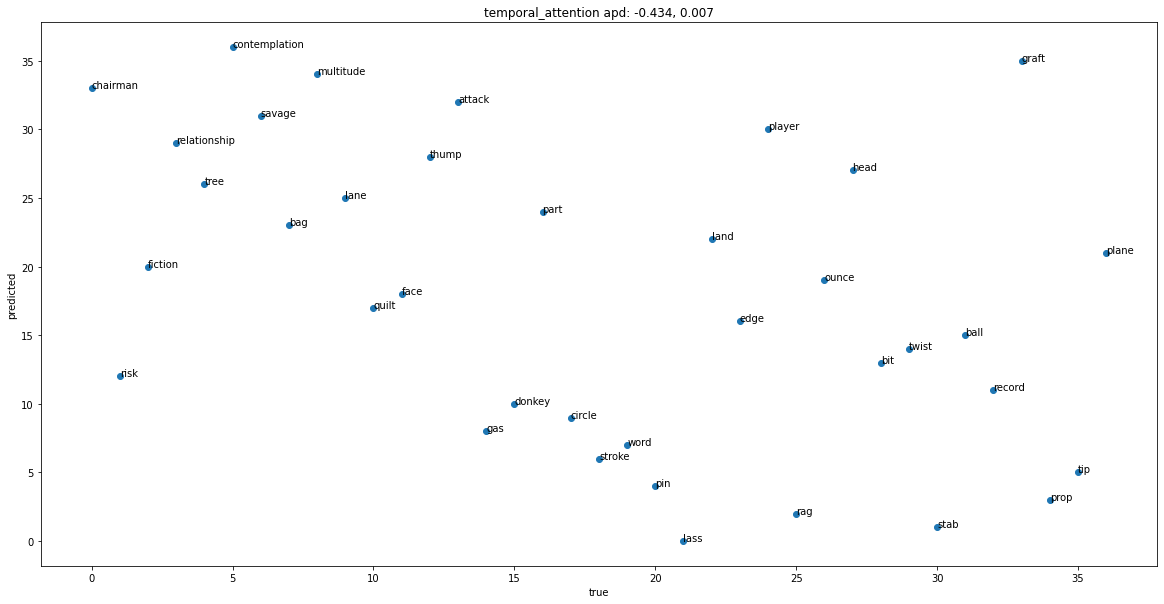

In [8]:
models_df['correlation'] = None
models_df['pvalue'] = None
for i, row in models_df.iterrows():
    cor, pv = plot_predictions(predictions_dict[i], f'{row["model"]} {row["method"]}')
    models_df.loc[i, 'correlation'] = cor
    models_df.loc[i, 'pvalue'] = pv   

In [37]:
models_df.sort_values('correlation', ascending=False)

,filename,model,method,nr_words,correlation,pvalue
6,..\data\semeval2020\prediction_histLM_bertbase...,histLM,apd,36,0.590551,0.000119
1,..\data\semeval2020\prediction_apd_macberth.txt,macberth,apd,31,0.577047,0.000185
4,..\data\semeval2020\prediction_bert-base-uncas...,bert-base-uncased,apd,36,0.561029,0.000304
0,..\data\semeval2020\prediction_cosine_macberth...,macberth,cosine,31,0.472259,0.003165
3,..\data\semeval2020\prediction_bert-base-uncas...,bert-base-uncased,cosine,36,0.31051,0.061419
5,..\data\semeval2020\prediction_histLM_bertbase...,histLM,cosine,36,0.258107,0.122981
2,..\data\semeval2020\prediction_jsd_macberth.txt,macberth,jsd,31,0.031722,0.852148
7,..\data\semeval2020\prediction_temporalattenti...,temporal_attention,cosine,37,0.01399,0.934502
8,..\data\semeval2020\prediction_temporalattenti...,temporal_attention,apd,37,-0.434169,0.007255


## Conclusion
The temporal attention model does not work correclty (as I already figured out in [this notebook](https://github.com/Semantics-of-Sustainability/temporal_attention/blob/main/TryModel.ipynb)).

ADP distance works much better than cosine and jsd. The scores of the other three models are quite close. But the historical models (histLM, MacBERTh) work better than the not-historical bert-base-uncased. histLM works better than MacBERTh, but note that MacBERTh is not trained on data after 1960, so the scores on corpus2 are less reliable. For HistLM, we can copare with the bert-base-uncased vectors for corpus 2, because it's a finetuned model with the same tokenization as bert-base-uncased. We cannot do this for MacBERTh. 

I would expect that a similar BERT model, pretrained on the complete period between 1810 en 2010 would work even better.  